# TP2 - MCMC

## Estimation avancée - G3 SDIA

Dans ce TP, on s'intéresse aux méthodes d'échantillonnage dites "MCMC" (Monte Carlo par Chaînes de Markov). Le premier exercice consiste à implémenter un Metropolis-Hastings et de regarder l'influence de quelques paramètres (disponible dans le premier notebook). Le deuxième exercice met en oeuvre une méthode de régression bayésienne linéaire.

### Instructions

1. Renommer votre notebook sous la forme `tp2b_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 10 Décembre 2023, 23h59.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn import datasets

### Partie 2 - Régression linéaire bayésienne parcimonieuse

On suppose le modèle de régression linéaire suivant :
$$ y_i \sim \mathcal{N}(\mathbf{x}_i^{\top} \boldsymbol{\beta}, \sigma^2)$$

On a :
* $y \in \mathbb{R}$, la variable que l'on cherche à prédire ;
* $\mathbf{x}_i \in \mathbb{R}^p$, les features ;
* $\boldsymbol{\beta} \in \mathbb{R}^p$, le vecteur de régression ;
* $\sigma^2$ la variance du bruit.

Nous adoptons une approche bayésienne. Les paramètres du modèle, $\boldsymbol{\beta}$ et $\sigma^2$, doivent donc être munis d'une loi a priori.

Dans cet exercice, nous allons suivre le modèle du *Bayesian LASSO* ([Park et al. (2008)](https://people.eecs.berkeley.edu/~jordan/courses/260-spring09/other-readings/park-casella.pdf)).

Le LASSO est une méthode de régression pénalisée classique (c'est la pénalisation en norme $\ell_1$ - vous connaissez la pénalisation en norme $\ell_2$ appelée *ridge regression*). Nous regardons ici sa version bayésienne. Les lois a priori sont les suivantes :
\begin{align}
\sigma^2 & \sim \text{IG}(a_0, b_0) \\
\beta_p | \sigma^2 & \sim \text{Laplace} \left( 0, \frac{\sqrt{\sigma^2}}{\lambda} \right)
\end{align}

$\lambda$ est le paramètre de régularisation. Il se trouve qu'en prenant une loi a priori de [Laplace](https://en.wikipedia.org/wiki/Laplace_distribution) pour les coefficients de régression, le problème du LASSO est le même que celui l'estimation MAP.

À partir des données $\mathcal{D} = \{ (\mathbf{x}_1, y_1), ... (\mathbf{x}_n, y_n) \}$, l'objectif est donc de caractériser la loi a posteriori $p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D})$. Elle n'est pas tractable analytiquement. Nous allons donc échantillonner de cette loi à l'aide d'un algorithme MCMC, plus précisémment, un [échantillonneur de Gibbs](https://fr.wikipedia.org/wiki/%C3%89chantillonnage_de_Gibbs).

Il n'est pas possible de dériver un échantillonneur de Gibbs immédiatement. Il se trouve que le modèle peut être ré-écrit de la manière suivante :
\begin{align}
\sigma^2 & \sim \text{IG}(a_0, b_0) \\
\tau_i^2 & \sim \text{Exp} \left( \frac{\lambda^2}{2} \right) \\
\beta_j | \tau_j^2, \sigma^2 & \sim \mathcal{N}(0, \sigma^2 \tau_j^2) \\
y_i | \boldsymbol{\beta}, \sigma^2 & \sim \mathcal{N}(\mathbf{x}_i^{\top} \boldsymbol{\beta}, \sigma^2)
\end{align}

On peut alors trouver les lois conditionnelles :
\begin{align}
\boldsymbol{\beta} | \boldsymbol{\tau}, \sigma^2, \mathcal{D} \sim \mathcal{N}(\mathbf{A} \mathbf{X}^{\top} \mathbf{y}, \sigma^2 \mathbf{A}),
\end{align}
avec $\mathbf{A} = (\mathbf{X}^{\top} \mathbf{X} + \mathbf{D}_{\tau})^{-1}$, où $\mathbf{D}_{\tau} = \text{diag}(\tau_1^{-2}, ..., \tau_p^{-2})$.
\begin{align}
\tau_j^{-2} | \boldsymbol{\beta}, \sigma^2, \mathcal{D} \sim \text{InvGaussian}\left( \sqrt{\frac{\lambda^2 \sigma^2}{\beta_j^2}}, \lambda^2 \right),
\end{align}
(Loi "Inverse-Gaussian" -> [ici](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution))
\begin{align}
\sigma^2 | \boldsymbol{\beta}, \boldsymbol{\tau}, \mathcal{D} \sim \text{IG}\left( a_0 + \frac{n+p}{2}, b_0 + \frac{1}{2} || \mathbf{y - X} \boldsymbol{\beta} ||^2_2 + \frac{1}{2} \sum_{j=1}^p \frac{\beta_j^2}{\tau_j^2} \right)
\end{align}

In [2]:
# Pre-processing the data

# Load the dataset
diabetes = datasets.load_diabetes()

# Print dataset description
print(diabetes.DESCR)

# Features
X = diabetes.data
X = X/np.std(X, axis = 0) # Standardize
N,P = X.shape

# Target
y = diabetes.target
y = (y-np.mean(y))/np.std(y) # Standardize

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

**Q1.** Écrire une fonction implémentant l'échantillonnage de Gibbs dans ce modèle, qui prend en arguments :
* Les données sous forme matricielle $\mathbf{X}$ et $\mathbf{y}$
* Le nombre d'échantillons $N_g$
* La taille du *burn-in* $N_b$
* Les hyper-paramètres du modèle : $a_0, b_0, \lambda$

Elle retourne $N_g$ échantillons du posterior $p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D})$.

**Attention !** Bien lire la doc. de `scipy.stats.invgauss` pour savoir quels paramètres utiliser.

In [4]:
def bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l):
    """
    Échantillonneur de Gibbs pour la régression linéaire bayésienne parcimonieuse (Bayesian LASSO).

    Parameters:
    - X: matrice des features
    - y: vecteur de la variable cible
    - Ng: nombre d'échantillons à générer
    - Nb: taille du burn-in
    - a0, b0, l: hyperparamètres du modèle

    Returns:
    - samples: liste des échantillons du posterior (beta, tau_sq_inv, sigma_sq)
    """

    # Initialisation
    n, p = X.shape
    beta = np.zeros(p)
    tau_sq_inv = np.ones(p + 1) 
    sigma_sq = 1  # Initialisation arbitraire

    # Matrice X augmentée avec une colonne de 1 pour l'intercept
    X_augmented = np.column_stack((np.ones(n), X))

    # Boucle pour les échantillons
    samples = []
    for _ in range(Ng + Nb):
        
        # Échantillonnage de beta
        A = np.linalg.inv(np.dot(X_augmented.T, X_augmented) + np.diag(tau_sq_inv))
        beta = np.random.multivariate_normal(np.dot(A, np.dot(X_augmented.T, y)), sigma_sq * A)

        # Échantillonnage de tau_sq_inv
        tau_sq_inv[1:] = ss.invgauss.rvs(np.sqrt(l**2 * sigma_sq / beta[1:]**2), l**2)

        # Échantillonnage de sigma_sq
        residuals = y - np.dot(X_augmented, beta)
        shape_param = a0 + (n + p) / 2
        rate_param = b0 + 0.5 * np.sum(residuals**2) + 0.5 * np.sum(beta[1:]**2 / tau_sq_inv[1:])
        sigma_sq = ss.invgamma.rvs(shape_param, scale=rate_param)

        # Sauvegarde des échantillons après la période de "burn-in"
        if _ >= Nb:
            samples.append((beta, tau_sq_inv, sigma_sq))

    return samples

**Q2.** Faire tourner la chaîne MCMC avec les paramètres suivants : $N_g = N_b = 1000$, $a_0 = b_0 = 1$, $\lambda = 10$.

* Afficher le *traceplot* pour un paramètre de votre choix. Commenter.
* Pour chacun des paramètres $\boldsymbol{\beta}$ et $\sigma^2$, afficher un histogramme ou un KDE des $N_g$ échantillons obtenus. Afficher sur le même plot la valeur de l'estimation MMSE et MAP. Enfin, donner l'intervalle de crédibilité à 95%. (Cf. dernier chapitre du cours Intro à l'Estimation)

In [5]:
# Paramètres
Ng = 1000
Nb = 1000
a0 = 1
b0 = 1
l = 10

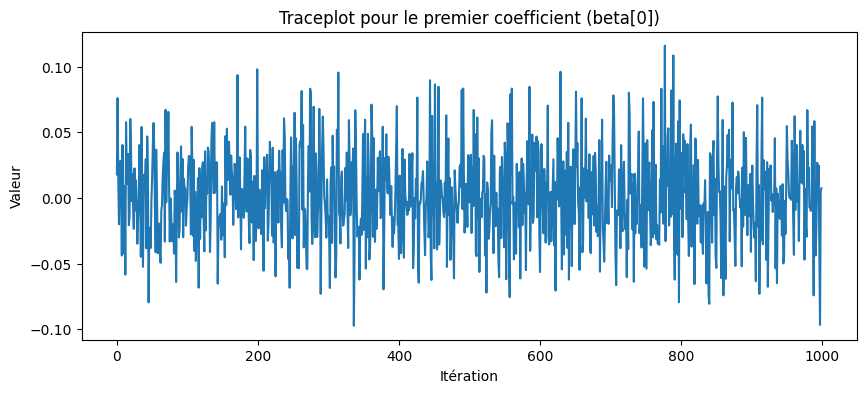

In [6]:
# Faire tourner la chaîne MCMC
samples = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l)

# Traceplot pour un paramètre de choix
plt.figure(figsize=(10, 4))
plt.plot([sample[0][0] for sample in samples])
plt.title('Traceplot pour le premier coefficient (beta[0])')
plt.xlabel('Itération')
plt.ylabel('Valeur')
plt.show()

c:\Users\mathc\AppData\Local\Programs\Python\Python38-32\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

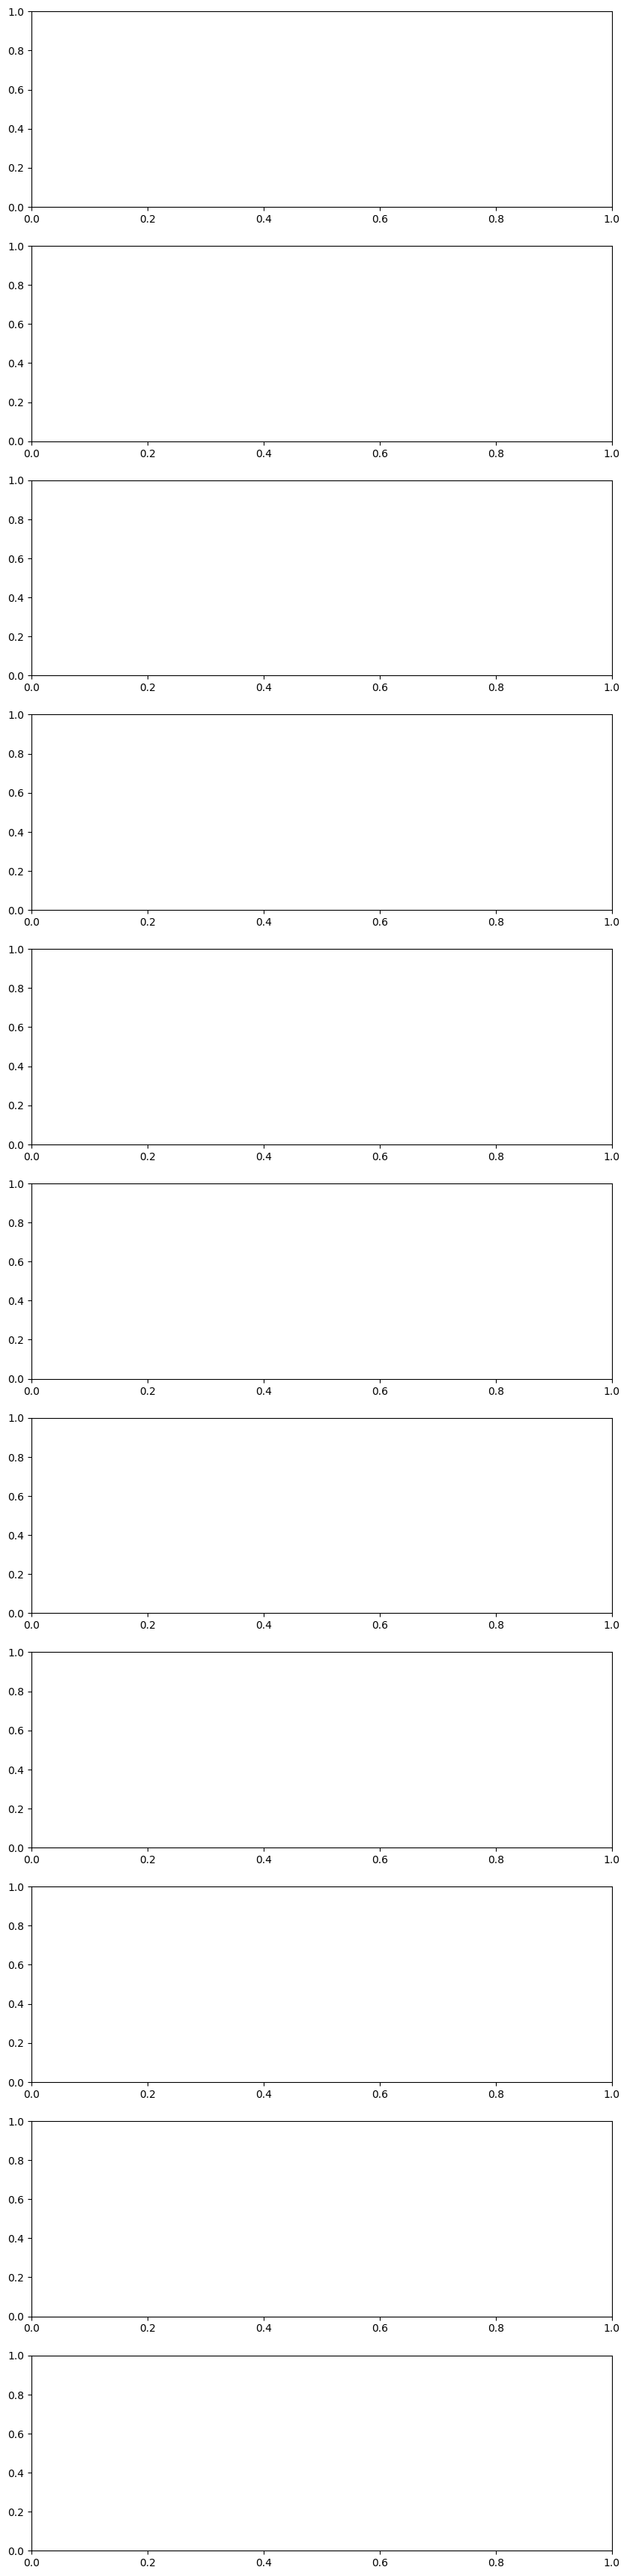

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assurez-vous d'avoir correctement défini le nombre de composantes dans votre vecteur de coefficients beta
num_components = len(samples[0][0])

# Créer un subplot pour chaque composante de beta
fig, axes = plt.subplots(nrows=num_components, ncols=1, figsize=(10, 4*num_components))

# Calculer les estimations MMSE et MAP pour chaque composante de beta
mmse_estimate = np.mean(samples, axis=0)[0]
map_estimate = np.mean(samples, axis=0)[0]  # Ajuster si nécessaire

# Parcourir chaque composante de beta
for j in range(num_components):
    values = [sample[0][j] for sample in samples]

    # Plot Histogramme avec histplot
    sns.histplot(values, bins=30, kde=True, color='blue', alpha=0.5, ax=axes[j])

    # Lignes pour les estimations MMSE et MAP
    axes[j].axvline(x=mmse_estimate[j], color='green', linestyle='dashed', label='Estimation MMSE')
    axes[j].axvline(x=map_estimate[j], color='red', linestyle='dashed', label='Estimation MAP')

    axes[j].set_title(f'Distribution pour Composante de Régression {j+1}')
    axes[j].set_xlabel(f'Composante de Régression {j+1}')
    axes[j].set_ylabel('Densité de probabilité')
    axes[j].legend()

# Ajuster la mise en page pour éviter les chevauchements
plt.tight_layout()
plt.show()


In [69]:
samples[0][0]

array([ 0.00599674,  0.01743554, -0.10816714,  0.29295222,  0.13166417,
       -0.00910182, -0.10632235, -0.11803472,  0.11654203,  0.23012094,
       -0.02596788])

Dire que intercept très petit (on l'a ajoute de nous meme) car data normalized mais qu'en general il est bien d'en avoir un 

In [44]:
# Calculer les estimations MMSE et MAP pour sigma^2
mmse_estimate_sigma = np.mean([sample[2] for sample in samples])
map_estimate_sigma = np.mean([sample[2] for sample in samples]) 

c:\Users\mathc\AppData\Local\Programs\Python\Python38-32\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


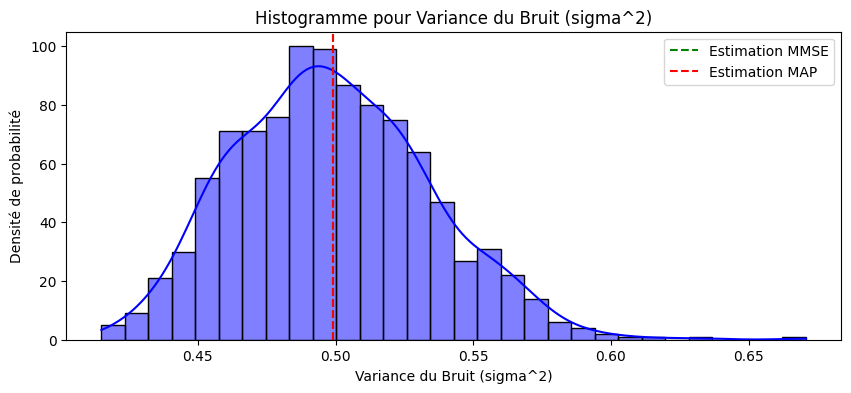

In [47]:
# Pour sigma^2
values_sigma = [sample[2] for sample in samples]  # Indice 2 car sigma^2 est le troisième élément dans chaque échantillon
plt.figure(figsize=(10, 4))
sns.histplot(values_sigma, bins=30, kde=True, color='blue', alpha=0.5)
plt.axvline(x=mmse_estimate_sigma, color='green', linestyle='dashed', label='Estimation MMSE')
plt.axvline(x=map_estimate_sigma, color='red', linestyle='dashed', label='Estimation MAP')
plt.title('Histogramme pour Variance du Bruit (sigma^2)')
plt.xlabel('Variance du Bruit (sigma^2)')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.show()

In [50]:
print(samples[0])

(array([ 0.00599674,  0.01743554, -0.10816714,  0.29295222,  0.13166417,
       -0.00910182, -0.10632235, -0.11803472,  0.11654203,  0.23012094,
       -0.02596788]), array([  1.        , 101.36993616, 102.7428643 , 108.05650964,
       104.5413479 , 112.4105952 , 101.17223474, 101.01990428,
       100.91279148, 103.59049404, 103.03676028]), 0.49381518686592407)


**Q3.** Générer 1000 échantillons de la loi prédictive a posteriori pour le nouveau point $x_{\text{new}}$ (défini dans le code) et tracer un histogramme ou un KDE. Commenter.

In [ ]:
x_new = np.array([ 1.41145807,  1.06548848,  0.30006161,  0.45984057, -0.52475728,
       -1.70643289,  1.02259953,  1.49710409, -1.25030999,  0.84817082])

#######
## YOUR CODE HERE
#######

**Q4.** Étudier l'influence du paramètre lambda sur l'inférence des paramètres.

Sans l'implémenter, à l'aide de vos connaissances, pouvez-vous proposer une méthode permettant de choisir lambda ?

In [ ]:
#######
## YOUR CODE HERE
#######

**Questions bonus**. Le TP est déjà long. Votre objectif premier est d'effectuer les questions précédentes correctement.

S'il vous reste du temps et de la motivation, voici deux questions "papier-crayon" :
* Montrer que l'estimation MAP dans un modèle avec un *prior* Laplace pour les coefficients de régression mène bien au même problème que le LASSO
* Dériver la loi conditionnelle pour $\boldsymbol{\beta}$ ou $\sigma^2$. Attention ! Le calcul de la loi conditionnelle de $\tau_i$ est quant à lui très compliqué. Ne le tentez pas sans l'aide d'un(e) professionnel(le).